# Parameter Identification Code:

Code Written by Nathan Mayer

Code Adapted from the Triple Pendulum Example, Solving Nonlinear Four-Bar Constraints, and Falling Rod Example Code Written by Professor Daniel Aukes

Triple Pendulum Example Code: https://foldable-robotics.github.io/modules/dynamics/generated/08-triple-pendulum-example/

## Pynamics Script:

In [ ]:
use_constraints = True

In [ ]:
# Import all necessary packages:

!pip install pynamics
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle
from pynamics.constraint import AccelerationConstraint,KinematicConstraint
import pynamics.integration
import numpy
import sympy
import scipy.optimize
import matplotlib.pyplot as plt
plt.ion()
from math import pi
import matplotlib as mpl
mpl.rcParams['animation.ffmpeg_path'] = r"C:\ffmpeg\ffmpeg\bin\ffmpeg.exe"

     |████████████████████████████████| 87 kB 2.3 MB/s 


In [ ]:
# Define Initial System:

system = System()
pynamics.set_system(__name__,system)

### Parametrization:

Link lengths were based off the dimensions of the biological model. The proportions of the entire canine limb were altered to be approximately 130 mm tall with each link being 50 mm. The end effector was chosen to be slightly longer to allow for more deflection in that link. Therefore, the end effector was chosen to be about 80mm long.

In [ ]:
# Create constant values for length, mass, springs, inertia, etc.

lA1 = Constant(0.05,'lA1',system) # Meters
lB1 = Constant(0.05,'lB1',system) # Meters
lC1 = Constant(0.05,'lC1',system) # Meters
lA2 = Constant(0.05,'lA2',system) # Meters
lB2 = Constant(0.05,'lB2',system) # Meters
lA31 = Constant(0.08*2/3,'lA31',system) # Meters
lA32 = Constant(0.08*1/3,'lA32',system) # Meters
lRig = Constant(0.2,'lRig',system) # Meters

mA1 = Constant(0.006,'mA1',system)
mB1 = Constant(0.006,'mB1',system)
mC1 = Constant(0.006,'mC1',system)
mA2 = Constant(0.006,'mA2',system)
mB2 = Constant(0.006,'mB2',system)
mA31 = Constant(0.006,'mA31',system)
mA32 = Constant(0.003,'A32',system)

m_end = Constant(0.001,'m_end',system)
mRig = Constant(0.2,'mRig',system)

g = Constant(9.81,'g',system) # acceleration due to gravity
b = Constant(1e-1,'b',system) # damping constant
k = Constant(1e-3,'k',system) # spring constant
k_ground = Constant(2e4,'k_ground',system) # ground spring constant
b_ground = Constant(8e5,'b_ground',system) # ground damping constant
k_endeffector = Constant(1e0,'k',system) # spring constant

# spring preloads
preload1 = Constant(0*pi/180,'preload1',system)
preload2 = Constant(0*pi/180,'preload2',system)
preload3 = Constant(0*pi/180,'preload3',system)
preload4 = Constant(0*pi/180,'preload4',system)
preload5 = Constant(0*pi/180,'preload5',system)
preload6 = Constant(0*pi/180,'preload6',system)
preload7 = Constant(0*pi/180,'preload7',system)

# link principal moments of inertia
Ixx_Rig = Constant(4.167*10**-9,'Ixx_Rig',system)
Iyy_Rig = Constant(1,'Iyy_Rig',system)
Izz_Rig = Constant(1.042*10**-7,'Izz_Rig',system)
Ixx_A1B1 = Constant(4.167*10**-9,'Ixx_A1B1',system)
Iyy_A1B1 = Constant(1,'Iyy_A1B1',system)
Izz_A1B1 = Constant(1.042*10**-7,'Izz_A1B1',system)
Ixx_B1C1 = Constant(4.167*10**-9,'Ixx_B1C1',system)
Iyy_B1C1 = Constant(1,'Iyy_B1C1',system)
Izz_B1C1 = Constant(1.042*10**-7,'Izz_B1C1',system)
Ixx_C1B2 = Constant(4.167*10**-9,'Ixx_C1B2',system)
Iyy_C1B2 = Constant(1,'Iyy_C1B2',system)
Izz_C1B2 = Constant(1.042*10**-7,'Izz_C1B2',system)
Ixx_A2B2 = Constant(4.167*10**-9,'Ixx_A2B2',system)
Iyy_A2B2 = Constant(1,'Iyy_A2B2',system)
Izz_A2B2 = Constant(1.042*10**-7,'Izz_A2B2',system)
Ixx_B2C1 = Constant(4.167*10**-9,'Ixx_B2C1',system)
Iyy_B2C1 = Constant(1,'Iyy_B2C1',system)
Izz_B2C1 = Constant(1.042*10**-7,'Izz_B2C1',system)
Ixx_C1A31 = Constant(4.444*10**-9,'Ixx_C1A31',system)
Iyy_C1A31 = Constant(1,'Iyy_C1A31',system)
Izz_C1A31 = Constant(1.264*10**-7,'Izz_C1A31',system)
Ixx_A31A32 = Constant(2.222*10**-9,'Ixx_A31A32',system)
Iyy_A31A32 = Constant(1,'Iyy_A31A32',system)
Izz_A31A32 = Constant(1.580*10**-7,'Izz_A31A32',system)


# input torques and frequencies
torque1 = Constant(0.2,'torque1',system)
torque2 = Constant(0.3,'torque2',system)

freq1 = Constant(0.2,'freq1',system)
freq2 = Constant(0.2,'freq2',system)

qA31 = Constant(0,'qA31',system)
qA1 = Constant(0,'qA1',system)
qOrigin = Constant(0,'qOrigin',system)

In [ ]:
# Differentiable State Variables:

qRig,qRig_d,qRig_dd = Differentiable('qRig',system)
qB1,qB1_d,qB1_dd = Differentiable('qB1',system)
qC1,qC1_d,qC1_dd = Differentiable('qC1',system)
qA2,qA2_d,qA2_dd = Differentiable('qA2',system)
qB2,qB2_d,qB2_dd = Differentiable('qB2',system)
qA32,qA32_d,qA32_dd = Differentiable('qA32',system)
lOrigin,lOrigin_d,lOrigin_dd = Differentiable('lOrigin',system)

In [ ]:
# Initial Values:

initialvalues = {}
initialvalues[qRig]=(0)*pi/180
initialvalues[qRig_d]=0*pi/180
initialvalues[qB1]=(-100)*pi/180
initialvalues[qB1_d]=0*pi/180
initialvalues[qC1]=(-50)*pi/180
initialvalues[qC1_d]=0*pi/180
initialvalues[qA2]=(-140)*pi/180
initialvalues[qA2_d]=0*pi/180
initialvalues[qB2]=(80)*pi/180
initialvalues[qB2_d]=0*pi/180
initialvalues[qA32]=(0)*pi/180
initialvalues[qA32_d]=0*pi/180
initialvalues[lOrigin]=0
initialvalues[lOrigin_d]=0

In [ ]:
statevariables = system.get_state_variables()
ini = [initialvalues[item] for item in statevariables]

### Kinematics:

In [ ]:
# Define All Frames:

Origin = Frame('O',system)
O = Frame('O',system)
Rig = Frame('Rig',system)
A1 = Frame('A1',system)
B1 = Frame('B1',system)
C1 = Frame('C1',system)
A2 = Frame('A2',system)
B2 = Frame('B2',system)
A31 = Frame('A31',system)
A32 = Frame('A32',system)

In [ ]:
# Define Newtonian Frame:

system.set_newtonian(Origin)

In [ ]:
# Define Frame Rotations:

O.rotate_fixed_axis(Origin,[0,0,1],qOrigin,system)
Rig.rotate_fixed_axis(O,[0,0,1],qRig,system)
A1.rotate_fixed_axis(Rig,[0,0,1],qA1,system)
B1.rotate_fixed_axis(A1,[0,0,1],qB1,system)
C1.rotate_fixed_axis(B1,[0,0,1],qC1,system)
A2.rotate_fixed_axis(Rig,[0,0,1],qA2,system)
B2.rotate_fixed_axis(A2,[0,0,1],qB2,system)
A31.rotate_fixed_axis(B2,[0,0,1],qA31,system)
A32.rotate_fixed_axis(A31,[0,0,1],qA32,system)

In [ ]:
# Create Point Vectors based on Frame Rotations:

pOrigin = 0*Origin.x
pO = pOrigin + lOrigin*O.x
pORig = pO + lRig*Rig.x
pRigA1 = pORig + 0*A1.x
pA1B1 = pRigA1 + lA1*A1.x
pB1C1 = pA1B1 + lB1*B1.x
pC1B2 = pB1C1 + lC1*C1.x

pRigA2 = pORig + 0*A2.x
pA2B2 = pRigA2 + lA2*A2.x
pB2C1 = pA2B2 + lB2*B2.x

pC1A31 = pB2C1 + lA31*A31.x
pA31A32 = pC1A31 + lA32*A32.x

In [ ]:
# Create Particle Entity to be Used in Ground Contact Force

Particle1 = Particle(pA31A32,m_end,'Particle1',system)
Particle2 = Particle(pA1B1,mRig,'Particle2',system)

In [ ]:
# Create an array of points:

points = [pC1B2,pB1C1,pA1B1,pRigA1,pRigA2,pO,pRigA1,pRigA2,pA2B2,pB2C1,pC1A31,pA31A32]

p = numpy.array(points)
points

[lA1*A1.x + lB1*B1.x + lC1*C1.x + lRig*Rig.x + lOrigin*O.x,
 lA1*A1.x + lB1*B1.x + lRig*Rig.x + lOrigin*O.x,
 lA1*A1.x + lRig*Rig.x + lOrigin*O.x,
 lRig*Rig.x + lOrigin*O.x,
 lRig*Rig.x + lOrigin*O.x,
 lOrigin*O.x,
 lRig*Rig.x + lOrigin*O.x,
 lRig*Rig.x + lOrigin*O.x,
 lA2*A2.x + lRig*Rig.x + lOrigin*O.x,
 lA2*A2.x + lB2*B2.x + lRig*Rig.x + lOrigin*O.x,
 lA2*A2.x + lA31*A31.x + lB2*B2.x + lRig*Rig.x + lOrigin*O.x,
 lA2*A2.x + lA31*A31.x + lA32*A32.x + lB2*B2.x + lRig*Rig.x + lOrigin*O.x]

In [ ]:
# Plot Estimated System Position:

l = len(p)

state1 = initialvalues


px = []
for i in range(0,l):
    q = p[i]
    x = q.dot(O.x)
    px.append(x)

px1 = [item.subs(state1) for item in px]
px1 = [item.subs(system.constant_values) for item in px1]
print('px1: ')
print(px1)

py = []
for i in range(0,l):
    q = p[i]
    y = q.dot(O.y)
    py.append(y)

py1 = [item.subs(state1) for item in py]
py1 = [item.subs(system.constant_values) for item in py1]
print('py1: ')
print(py1)

pz = []
for i in range(0,l):
    q = p[i]
    z = q.dot(O.z)
    pz.append(z)

pz1 = [item.subs(state1) for item in pz]
pz1 = [item.subs(system.constant_values) for item in pz1]
print('pz1: ')
print(pz1)

px1: 
[0.198016320927432, 0.241317591116653, 0.250000000000000, 0.200000000000000, 0.200000000000000, 0, 0.200000000000000, 0.200000000000000, 0.161697777844051, 0.186697777844051, 0.213364444510718, 0.226697777844051]
py1: 
[-0.0742403876506104, -0.0492403876506104, 0, 0, 0, 0, 0, 0, -0.0321393804843270, -0.0754406506735489, -0.121628672208719, -0.144722682976304]
pz1: 
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


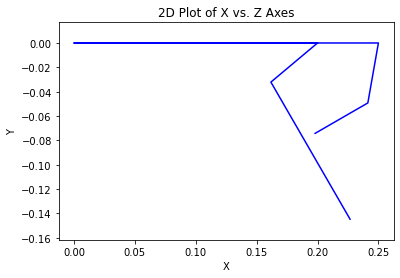

In [ ]:
# 2D Plot (X vs. Z Axes)

plt.plot(px1[0:4],py1[0:4],'b')
plt.plot(px1[4:l],py1[4:l],'b')
plt.axis('equal')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Plot of X vs. Z Axes');

### Solve for valid initial condition determined by independent variable:

In [ ]:
# Setup Optimization Equations:

ini0 = [initialvalues[item] for item in statevariables]

eq_vector = [pB2C1-pC1B2] # Output Should be Zero when End Points from Each Segment are Subtracted

eq_scalar = []
eq_scalar.append((eq_vector[0]).dot(O.x))
eq_scalar.append((eq_vector[0]).dot(O.y))

eq_scalar

[lA1*sin(qA1)*sin(qRig) - lA1*cos(qA1)*cos(qRig) - lA2*sin(qA2)*sin(qRig) + lA2*cos(qA2)*cos(qRig) - lB1*(-sin(qA1)*sin(qRig) + cos(qA1)*cos(qRig))*cos(qB1) - lB1*(-sin(qA1)*cos(qRig) - sin(qRig)*cos(qA1))*sin(qB1) + lB2*(-sin(qA2)*sin(qRig) + cos(qA2)*cos(qRig))*cos(qB2) + lB2*(-sin(qA2)*cos(qRig) - sin(qRig)*cos(qA2))*sin(qB2) - lC1*(-sin(qA1)*sin(qRig) + cos(qA1)*cos(qRig))*(-sin(qB1)*sin(qC1) + cos(qB1)*cos(qC1)) - lC1*(-sin(qA1)*cos(qRig) - sin(qRig)*cos(qA1))*(sin(qB1)*cos(qC1) + sin(qC1)*cos(qB1)), -lA1*sin(qA1)*cos(qRig) - lA1*sin(qRig)*cos(qA1) + lA2*sin(qA2)*cos(qRig) + lA2*sin(qRig)*cos(qA2) - lB1*(-sin(qA1)*sin(qRig) + cos(qA1)*cos(qRig))*sin(qB1) - lB1*(sin(qA1)*cos(qRig) + sin(qRig)*cos(qA1))*cos(qB1) + lB2*(-sin(qA2)*sin(qRig) + cos(qA2)*cos(qRig))*sin(qB2) + lB2*(sin(qA2)*cos(qRig) + sin(qRig)*cos(qA2))*cos(qB2) - lC1*(-sin(qA1)*sin(qRig) + cos(qA1)*cos(qRig))*(sin(qB1)*cos(qC1) + sin(qC1)*cos(qB1)) - lC1*(sin(qA1)*cos(qRig) + sin(qRig)*cos(qA1))*(-sin(qB1)*sin(qC1) + c

In [ ]:
# Define Independent and Dependent Variables

qi = [qA2,qB1]
qd = [qRig,qC1,qB2]

eq_scalar_c = [item.subs(system.constant_values) for item in eq_scalar]

defined = dict([(item,initialvalues[item]) for item in qi])
eq_scalar_c = [item.subs(defined) for item in eq_scalar_c]
eq_scalar_c

error = (numpy.array(eq_scalar_c)**2).sum()
print(error)

0.00633931466556407*(0.627984391633901*(-0.17364817766693*sin(qC1) - 0.984807753012208*cos(qC1))*sin(qRig) - 0.627984391633901*(0.984807753012208*sin(qC1) - 0.17364817766693*cos(qC1))*cos(qRig) + 0.627984391633901*(0.642787609686539*sin(qRig) - 0.766044443118978*cos(qRig))*cos(qB2) + 0.627984391633901*(0.766044443118978*sin(qRig) + 0.642787609686539*cos(qRig))*sin(qB2) - 0.21478331163291*sin(qRig) - cos(qRig))**2 + 0.00633931466556407*(-0.627984391633901*(-0.17364817766693*sin(qC1) - 0.984807753012208*cos(qC1))*cos(qRig) - 0.627984391633901*(0.984807753012208*sin(qC1) - 0.17364817766693*cos(qC1))*sin(qRig) + 0.627984391633901*(-0.766044443118978*sin(qRig) - 0.642787609686539*cos(qRig))*cos(qB2) + 0.627984391633901*(0.642787609686539*sin(qRig) - 0.766044443118978*cos(qRig))*sin(qB2) - sin(qRig) + 0.21478331163291*cos(qRig))**2


In [ ]:
f = sympy.lambdify(qd,error)

def function(args):
    return f(*args)

In [ ]:
# Define Initial Guess and Use Optimize Equation to Find Actual Angles:

guess = [initialvalues[item] for item in qd]

result = scipy.optimize.minimize(function,guess)
if result.fun>1e-3:
    raise(Exception("out of tolerance"))

In [ ]:
# Save New Points to Plot the Actual System Results:

ini_c = []
for item in system.get_state_variables():
    if item in qd:
        ini_c.append(result.x[qd.index(item)])
    else:
        ini_c.append(initialvalues[item])

In [ ]:
# Display Error from Optimization Equation:
result.fun

7.943263812780144e-10

2022-04-27 20:41:38,042 - pynamics.output - INFO - calculating outputs
2022-04-27 20:41:38,048 - pynamics.output - INFO - done calculating outputs


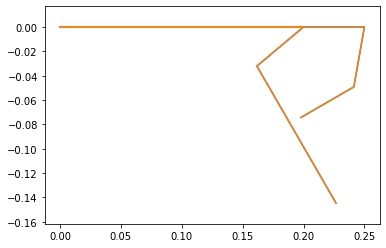

In [ ]:
# Plot Calculated System (Orange) vs. Initial Guess (Blue)
points = PointsOutput(points, constant_values=system.constant_values)
points.calc(numpy.array([ini0,ini]),numpy.array([0,1]))
points.plot_time()

In [ ]:
result.x

array([ 5.71851662e-10, -9.89244645e-01,  1.61299201e+00])

In [ ]:
# Define a new State for Joint Angles based on Optimization Equation:

state2 = {}
state2[qRig] = result.x[0]
state2[qRig_d] = 0*pi/180
state2[qB1]= initialvalues[qB1]
state2[qB1_d] = 0*pi/180
state2[qC1] = result.x[1]
state2[qC1_d] = 0*pi/180
state2[qA2] = initialvalues[qA2]
state2[qA2_d] = 0*pi/180
state2[qB2] = result.x[2]
state2[qB2_d] = 0*pi/180

# Load Tracker Data for Canine End Effector Position:

In [ ]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import scipy.interpolate as si

df=pd.read_csv(r'C:\Users\kingo\Desktop\Classes\Spring 2022\EGR 557\Parameter Identification\Dog Tracking\Dog Tracking Data.csv', sep=',')

x = df.x.to_numpy()
y = df.y.to_numpy()
t = df.t.to_numpy()

plt.figure()
plt.plot(t,x)

plt.figure()
plt.plot(t,y)

SyntaxError: ignored

In [ ]:
#df

In [ ]:
# Time:

tinitial = 0
tfinal = 10
fps = 30
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]

## Calculation of Equation for End Effector X-Postion:

In [ ]:
f_c = 3.14/6.6
Offset_x = -3.14/7
A = numpy.array([numpy.sin(system.t*f_c+Offset_x)]).T

TypeError: ignored

In [ ]:
def myfunc(k):
    # make sure our coefficients are in the form of a numpy array
    k = numpy.array(k)
    # generate y* = Ak^T
    x_model = A.dot(k.T)
    # sum the square of the error of our model against the input data, y_rand
    error = ((x_model-x)**2).sum
    #return the error
    return error

In [ ]:
ini = [0.1]*A.shape[1]
ini

In [ ]:
sol = scipy.optimize.minimize(myfunc,ini)
k_optimum = sol.x
k_optimum

In [ ]:
x_model = A.dot(k_optimum.T)
fig = plt.figure()
ax = fig.add_subplot()
a = ax.plot(t,x,'.')
b = ax.plot(t,x_model)
ax.legend(a+b,['data','model'])

In [ ]:
x_c = k_optimum.item()
x_c

## Calculation of Equation for End Effector Y-Postion:

In [ ]:
Offset_y = 3.14/2
A = numpy.array([numpy.sin(system.t*f_c+Offset_y)]).T

In [ ]:
def myfunc(k):
    # make sure our coefficients are in the form of a numpy array
    k = numpy.array(k)
    # generate y* = Ak^T
    y_model = A.dot(k.T)
    # sum the square of the error of our model against the input data, y_rand
    error = ((y_model-y)**2).sum()
    #return the error
    return error

In [ ]:
ini = [0.1]*A.shape[1]
ini

In [ ]:
sol = scipy.optimize.minimize(myfunc,ini)
k_optimum = sol.x
k_optimum

In [ ]:
y_model = A.dot(k_optimum.T)
fig = plt.figure()
ax = fig.add_subplot()
a = ax.plot(t,y,'.')
b = ax.plot(t,y_model-0.11)
ax.legend(a+b,['data','model'])

In [ ]:
y_c = k_optimum.item()
y_c

In [ ]:
x = x_c*numpy.sin(t*f_c)
y = y_c*numpy.sin(t*f_c+Offset_y)-0.13
plt.figure()
plt.plot(x,y)

In [ ]:
#pEnd = pORig + (x_c*sympy.sin(system.t*f_c))*O.x + (y_c*sympy.sin(system.t*f_c+Offset_y)-0.12)*O.y
#pEnd
pEnd = pORig + (-0.0749732645592911*sympy.sin(0.475757575757576*system.t))*O.x + (-0.0217365930025405*sympy.sin(0.475757575757576*system.t + 1.57)-0.12)*O.y
pEnd

# Dynamics Simulation:

## Centers of Mass:

The centers of mass of each link are taken at the centers of their respective linear segments.

In [ ]:
pORigcm = pO +lRig*O.x
pA1B1cm=pRigA1+lA1/2*A1.x
pB1C1cm=pA1B1+lB1/2*B1.x
pC1B2cm=pB1C1+lC1/2*C1.x
pA2B2cm=pRigA2+lA2/2*A2.x
pB2C1cm=pA2B2+lB2/2*B2.x
pC1A31cm=pC1A31+lA31/2*A31.x
pA31A32cm=pA31A32+lA32/2*A32.x

## Angular Velocity:

In [ ]:
wORig = O.get_w_to(Rig)
wRigA1 = Rig.get_w_to(A1)
wA1B1 = A1.get_w_to(B1)
wB1C1 = B1.get_w_to(C1)
wRigA2 = Rig.get_w_to(A2)
wA2B2 = A2.get_w_to(B2)
wB2C1 = B2.get_w_to(C1)
wC1A31 = C1.get_w_to(A31)
wA31A32 = A31.get_w_to(A32)

## Vector Derivatives:

In [ ]:
vA3tip = pA31A32.time_derivative(O,system)
vA1B1 = pA1B1.time_derivative(O,system)

## Define Inertias and Bodies:

Inertias and bodies are constructed from previosly defined masses, centers of mass, and moments of intertia.

In [ ]:
IRig = Dyadic.build(Rig,Ixx_Rig,Iyy_Rig,Izz_Rig)
IA1B1 = Dyadic.build(A1,Ixx_A1B1,Iyy_A1B1,Izz_A1B1)
IB1C1 = Dyadic.build(B1,Ixx_B1C1,Iyy_B1C1,Izz_B1C1)
IC1B2 = Dyadic.build(C1,Ixx_C1B2,Iyy_C1B2,Izz_C1B2)
IA2B2 = Dyadic.build(A2,Ixx_A2B2,Iyy_A2B2,Izz_A2B2)
IB2C1 = Dyadic.build(B2,Ixx_B2C1,Iyy_B2C1,Izz_B2C1)
IC1A31 = Dyadic.build(A31,Ixx_C1A31,Iyy_C1A31,Izz_C1A31)
IA31A32 = Dyadic.build(A32,Ixx_A31A32,Iyy_A31A32,Izz_A31A32)

BodyRig = Body('BodyRig',Rig,pORigcm,mRig,IRig,system)
BodyA1B2 = Body('BodyA1B1',A1,pA1B1cm,mA1,IA1B1,system)
BodyB1C1 = Body('BodyB1C1',B1,pB1C1cm,mB1,IB1C1,system)
BodyC1B2 = Body('BodyC1B2',C1,pC1B2cm,mC1,IC1B2,system)
BodyA2B2 = Body('BodyA2B2',A2,pA2B2cm,mA2,IA2B2,system)
BodyB2C1 = Body('BodyB2C1',B2,pB2C1cm,mB2,IB2C1,system)
BodyC1A31 = Body('BodyC1A31',A31,pC1A31cm,mA31,IC1A31,system)
BodyA31A32 = Body('BodyA31A32',A32,pA31A32cm,mA32,IA31A32,system)

## Forces and Torques: (Using Pynamics Simulation)

Two sinusoidal input torques are considered acting at joints $p(RigA_1)$ and $p(A_1A_2)$. These torques currently have an amplitude of 1 N*m but can be adjusted later.

Dampers and spring forces are added to each of the joints so that their values can be studied and different combinations can be tested in the future. Gravity and ground contact forces are included as well.

In [ ]:
# Damper:

system.addforce(-b*wRigA1,wRigA1)
system.addforce(-b*wA1B1,wA1B1)
system.addforce(-b*wB1C1,wB1C1)
system.addforce(-b*wRigA2,wRigA2)
system.addforce(-b*wA2B2,wA2B2)
system.addforce(-b*wC1A31,wC1A31)
system.addforce(-b*wA31A32,wA31A32)

In [ ]:
# Spring Forces:

system.add_spring_force1(k,(qA1-preload1)*Rig.z,wRigA1) 
system.add_spring_force1(k,(qB1-preload2)*A1.z,wA1B1)
system.add_spring_force1(k,(qC1-preload3)*B1.z,wB1C1)
system.add_spring_force1(k,(qA2-preload4)*Rig.z,wRigA2) 
system.add_spring_force1(k,(qB2-preload5)*A2.z,wA2B2)
system.add_spring_force1(k,(qA31-preload6)*B2.z,wC1A31)
system.add_spring_force1(k,(qA32-preload7)*B2.z,wA31A32)

In [ ]:
# Gravity:

system.addforcegravity(-g*O.y)

In [ ]:
# Ground Contact Force

y1 = pA31A32.dot(O.y)
yg1 = -0.12
f_floor1 = ((y1 - yg1)**2)**.5 - (y1 - yg1)    # Assume Ground at y = -0.14

f_floor1_d = system.derivative(f_floor1)
#system.addforce(-k_ground*f_floor1*-O.y,vA3tip)
#system.addforce(-b_ground*f_floor1*vA3tip,vA3tip)

y2 = pA1B1.dot(O.y)
yg2 = 0
f_floor2 = ((y2 - yg2)**2)**.5 - (y2 - yg2)    # Assume Contact at y = 0

f_floor2_d = system.derivative(f_floor2)
system.addforce(-k_ground*f_floor2*-O.y,vA1B1)
system.addforce(-b_ground*f_floor2*vA1B1,vA1B1)


## Constraints:

Because this system is a parallel mechanism, acceleration constraints are required to keep the two "sides" of the mechanism connected throughout their motion while also keeping the top link fixed in place.

In [ ]:
if use_constraints:

    eq1 = []
    eq1.append(pB2C1-pC1B2)
    eq1_d=[item.time_derivative() for item in eq1]
    eq1_dd=[item.time_derivative() for item in eq1_d]
    eq1_dd_scalar = []
    eq1_dd_scalar.append(eq1_dd[0].dot(O.x))
    eq1_dd_scalar.append(eq1_dd[0].dot(O.y))

    eq2 = []
    eq2.append(pA31A32-pEnd)
    eq2_d=[item.time_derivative() for item in eq2]
    eq2_dd=[item.time_derivative() for item in eq2_d]
    eq2_dd_scalar = []
    #eq2_dd_scalar.append(eq2_dd[0].dot(O.x))
    eq2_dd_scalar.append(eq2_dd[0].dot(O.y))

    constraint1 = AccelerationConstraint(eq1_dd_scalar)
    constraint2 = AccelerationConstraint(eq2_dd_scalar)

    system.add_constraint(constraint1)  # Kinematic Constraint
    system.add_constraint(constraint2)  # End Effector Constraint

## F = ma

In [ ]:
f,ma = system.getdynamics()

In [ ]:
#f

In [ ]:
# ma

## Solve for Acceleration:

In [ ]:
func1,lambda1 = system.state_space_post_invert(f,ma,return_lambda = True)

## Integration Tolerance:

In [ ]:
tol = 1e-4

In [ ]:
# Time:

tinitial = 0
tfinal = 10
fps = 30
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]

## Integrate:

In [ ]:
states=pynamics.integration.integrate(func1,ini_c,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))

## Outputs:

In [ ]:
# States:

plt.figure()
artists = plt.plot(t,states[:,:3])
plt.legend(artists,['qA','qB','qC'])

In [ ]:
# Energy:

KE = system.get_KE()
PE = system.getPEGravity(pRigA1) - system.getPESprings()
energy_output = Output([KE-PE],system)
energy_output.calc(states,t)
energy_output.plot_time()

Note that the total energy  of the system does not purely decay over time because the sinusoidal input torques add energy to the system.

In [ ]:
# Constraint Forces:

if use_constraints:
    lambda2 = numpy.array([lambda1(item1,item2,system.constant_values) for item1,item2 in zip(t,states)])
    plt.figure()
    plt.plot(t, lambda2)

In [ ]:
# Motion:

points = points = [pC1B2,pB1C1,pA1B1,pRigA1,pRigA2,pO,pRigA1,pRigA2,pA2B2,pB2C1,pC1A31,pA31A32]
points_output = PointsOutput(points,system)
y = points_output.calc(states,t)
points_output.plot_time(20)

In [ ]:
# Motion Animation:

points_output.animate(fps = fps,movie_name = 'triple_pendulum.mp4',lw=2,marker='o',color=(1,0,0,1),linestyle='-')
from matplotlib import animation, rc
from IPython.display import HTML
HTML(points_output.anim.to_html5_video())

## Bibliography:

[1] J. Kim, K. A. Kazmierczak, and G. J. Breur, “Comparison of temporospatial and kinetic variables of walking in small and large dogs on a pressure-sensing walkway,” *American Journal of Veterinary Research*, vol. 72, no. 9, pp. 1171–1177, 2011.

[2] https://www.youtube.com/watch?v=rAvOPCp6Itk